# Shmoo Plot Demo

In [2]:
# Equipment setup

import pyvisa
import serial
import shlex
import subprocess
import time

# Establish connection to the power supply
rm = pyvisa.ResourceManager("@py")

# psu = rm.open_resource('TCPIP::169.254.58.10::gpib0,7::INSTR')                  ## for the Agilent power supply

psu = rm.open_resource('TCPIP::169.254.201.77::lan0::INSTR')                    ## for the Keysight power supply

clk = rm.open_resource('TCPIP::169.254.201.101::lan0::INSTR')

# Need to verify that this is the power supply. psu_verification should be 
# something like "Keysight Technologies,E3646A,0,X.X-Y.Y-Z.Z"
psu_verification = psu.query("*IDN?")
clk_verification = clk.query("*IDN?")

print("Power supply:", psu_verification)
print("Clock generator:", clk_verification)

# psu.write("*RST")  # Reset the power supply

start_voltage = 0.5

end_voltage = 1.25

step_size = 0.05  

start_clock = 250

end_clock = 850

step_size_clock = 50

# Loop through the voltage range and set the voltage
current_voltage = start_voltage 

current_clock = start_clock

psu.write("OUTP ON, (@2)")

# Only channel 2 works
# psu.write("INST:SEL OUT2")
psu.write("INST:SEL CH2")

# Set current to 500mA
psu.write("CURR 0.5")

# Start the clock at 20MHz
clk.write(":OUTP1:POS ON") # Initialize clk gen channel 1 output
clk.write(":FUNC:PATT")


# expected_output = "32767 32767 32767 32767 32767 32767 32767 32767 32767 32767"
expected_output = "0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000"

VisaIOError: VI_ERROR_RSRC_NFOUND (-1073807343): Insufficient location information or the requested device or resource is not present in the system.

In [2]:
import shlex
import pyvisa
import time
import subprocess
import serial

start_voltage = 0.5

end_voltage = 1.25

step_size = 0.05  

start_clock = 250

end_clock = 850

step_size_clock = 50

# Loop through the voltage range and set the voltage
current_voltage = start_voltage 

current_clock = start_clock

expected_output = "4000 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000"
while current_clock <= end_clock:
     # remake to adjust with the frequency
    #  subprocess.run(["make", "clean"], cwd="../../")

    #  with open("../../platform/dsp24/freq.h", "w") as f:
    #       f.write('''#ifndef __FREQ_H
    #                 #define __FREQ_H
    #                 ''')
    #       f.write(f'''#define MTIME_FREQ     {current_clock}000000
    #                 #define SYS_CLK_FREQ   {current_clock}000000
    #                 ''')
    #       f.write("#endif")

    #  subprocess.run(["make", "shmoo_dsp"], cwd="../../")

    #  clk.write(":FREQ 100MHz")
    #  print(f"**Clock set to: {current_clock}MHz**") 


     while current_voltage <= end_voltage: # Set the voltage   
        #   psu.write(f"VOLT {current_voltage}")

        #   voltage = psu.query("VOLT?") 
        #   print(f"**Voltage set to: {voltage}V**") 

          openocd_args = shlex.split("openocd -f platform/dsp24/dsp24.cfg")
          gdb_args = shlex.split('riscv64-unknown-elf-gdb ../../build/shmoo_bench.elf --eval-command="target extended-remote localhost:3333" --eval-command="monitor reset" --eval-command="load" --eval-command="continue"')
          print(gdb_args)
          ratio_integer = hex(int(current_clock / 50))
          openocd = subprocess.Popen(["/tools/C/ee290-fa24-2/.conda-env/bin/openocd", "-f", "platform/dsp24/dsp24.cfg"], cwd="/tools/C/tedkim7/sp24-Baremetal-IDE")
          gdb = subprocess.Popen(gdb_args)

          measured_voltages = []
          measured_currents = []
          start_time = time.time()
          timeout = False
          with serial.Serial('/dev/ttyUSB1', 115200, timeout=7) as ser:
               while (ser.inWaiting() == 0):
                    ## measure the voltage + current
                    if time.time() - start_time >= 7:
                         timeout = True
                         break
                    # measured_voltages.append(psu.query("MEAS:VOLT?"))
                    # measured_currents.append(psu.query("MEAS:CURR?"))
                    # measured_voltages.append(5)
                    # measured_currents.append(5)
               if timeout:
                    length = min(len(measured_currents), len(measured_voltages))
                    print("timed out")
                    # power_consumption = sum([float(measured_voltages[i]) * float(measured_currents[i]) for i in range(length)]) / length
                    # with open('../../output.txt', 'a') as file:
                    #      file.write(f"Freq: {current_clock}, Voltage: {current_voltage}, Output: Invalid, Power: {power_consumption}\n")
                    #      gdb.terminate()
                    #      gdb.wait()     
               else:
                    line = ser.readline()
                    print(line)
                    new_line = line.decode("utf-8")


                    res = "Valid"
                    if not new_line.strip() == expected_output.strip():
                         res = "Invalid"

                    print(res)
                    
                    ## calculate power consumption
                    length = min(len(measured_currents), len(measured_voltages))
                    # power_consumption = sum([float(measured_voltages[i]) * float(measured_currents[i]) for i in range(length)]) / length
                    # with open('../../output.txt', 'a') as file:
                    #      file.write(f"Freq: {current_clock}, Voltage: {current_voltage}, Output: {res}, Power {power_consumption}\n")
                    #      gdb.terminate()
                    #      gdb.wait()
          gdb.kill()
          openocd.kill()
          time.sleep(3)

          current_voltage += step_size
     current_voltage = start_voltage
     current_clock += step_size_clock

print("Finished")

# psu.close()

current_clock = start_clock
current_voltage = start_voltage

['riscv64-unknown-elf-gdb', '../../build/shmoo_bench.elf', '--eval-command=target extended-remote localhost:3333', '--eval-command=monitor reset', '--eval-command=load', '--eval-command=continue']


Open On-Chip Debugger 0.12.0+dev-00772-g40d58ce52 (2024-11-07-12:34)
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html
Info : clock speed 2000 kHz
Info : JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc), part: 0x0000, ver: 0x2)
Info : datacount=8 progbufsize=16
Info : Disabling abstract command reads from CSRs.
Info : Vector support with vlenb=32
Info : Examined RISC-V core; found 4 harts
Info :  hart 0: XLEN=64, misa=0x800000000034112d
Info : [riscv.cpu0] Examination succeed
Info : [riscv.cpu0] starting gdb server on 3333
Info : Listening on port 3333 for gdb connections
Ready for Remote Connections
Info : Listening on port 6666 for tcl connections
Info : Listening on port 4444 for telnet connections


GNU gdb (GDB) 14.1
Copyright (C) 2023 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.
Type "show copying" and "show warranty" for details.
This GDB was configured as "--host=x86_64-pc-linux-gnu --target=riscv64-unknown-elf".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<https://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resources online at:
    <http://www.gnu.org/software/gdb/documentation/>.

For help, type "help".
Type "apropos word" to search for commands related to "word"...
Reading symbols from ../../build/shmoo_bench.elf...
Remote debugging using localhost:3333
0x00000000800011f4 in _exit ()
Loading section .text, size 0xa91e lma 0x80000000


Info : accepting 'gdb' connection on tcp/3333
Info : JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc), part: 0x0000, ver: 0x2)
JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc), part: 0x0000, ver: 0x2)


Loading section .rodata, size 0x938 lma 0x8000a920
Loading section .data, size 0xb30 lma 0x8000b258
Loading section .sdata, size 0x38 lma 0x8000bd88
Start address 0x0000000080000000, load size 48574
Transfer rate: 83 KB/sec, 8095 bytes/write.
Continuing.
b'4000 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Valid
Done: now reset during the sleep before next iteration


Info : Disabling abstract command writes to CSRs.


['riscv64-unknown-elf-gdb', '../../build/shmoo_bench.elf', '--eval-command=target extended-remote localhost:3333', '--eval-command=monitor reset', '--eval-command=load', '--eval-command=continue']
GNU gdb (GDB) 14.1
Copyright (C) 2023 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.
Type "show copying" and "show warranty" for details.
This GDB was configured as "--host=x86_64-pc-linux-gnu --target=riscv64-unknown-elf".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<https://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resources online at:
    <http://www.gnu.org/software/gdb/documentation/>.

For help, type "help".
Type "apropos word" to search for commands related to "word"...
Reading symbols from ../../build/shmoo_bench.elf..

Open On-Chip Debugger 0.12.0+dev-00772-g40d58ce52 (2024-11-07-12:34)
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html
Info : clock speed 2000 kHz
Info : JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc), part: 0x0000, ver: 0x2)
Info : datacount=8 progbufsize=16
Info : Disabling abstract command reads from CSRs.
Info : Vector support with vlenb=32
Info : Examined RISC-V core; found 4 harts
Info :  hart 0: XLEN=64, misa=0x800000000034112d
Info : [riscv.cpu0] Examination succeed
Info : [riscv.cpu0] starting gdb server on 3333
Info : Listening on port 3333 for gdb connections
Ready for Remote Connections
Info : Listening on port 6666 for tcl connections
Info : Listening on port 4444 for telnet connections
Info : accepting 'gdb' connection on tcp/3333
Info : JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc), part: 0x0000, ver: 0x2)
JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc

Loading section .rodata, size 0x938 lma 0x8000a920
Loading section .data, size 0xb30 lma 0x8000b258
Loading section .sdata, size 0x38 lma 0x8000bd88
Start address 0x0000000080000000, load size 48574


Info : Disabling abstract command writes to CSRs.


Transfer rate: 86 KB/sec, 8095 bytes/write.
Continuing.
b'4000 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Valid
Done: now reset during the sleep before next iteration
['riscv64-unknown-elf-gdb', '../../build/shmoo_bench.elf', '--eval-command=target extended-remote localhost:3333', '--eval-command=monitor reset', '--eval-command=load', '--eval-command=continue']
GNU gdb (GDB) 14.1
Copyright (C) 2023 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.
Type "show copying" and "show warranty" for details.
This GDB was configured as "--host=x86_64-pc-linux-gnu --target=riscv64-unknown-elf".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<https://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resource

Open On-Chip Debugger 0.12.0+dev-00772-g40d58ce52 (2024-11-07-12:34)
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html
Info : clock speed 2000 kHz
Info : JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc), part: 0x0000, ver: 0x2)
Info : datacount=8 progbufsize=16
Info : Disabling abstract command reads from CSRs.
Info : Vector support with vlenb=32
Info : Examined RISC-V core; found 4 harts
Info :  hart 0: XLEN=64, misa=0x800000000034112d
Info : [riscv.cpu0] Examination succeed
Info : [riscv.cpu0] starting gdb server on 3333
Info : Listening on port 3333 for gdb connections
Ready for Remote Connections
Info : Listening on port 6666 for tcl connections
Info : Listening on port 4444 for telnet connections
Info : accepting 'gdb' connection on tcp/3333
Info : JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc), part: 0x0000, ver: 0x2)
JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc

Loading section .rodata, size 0x938 lma 0x8000a920
Loading section .data, size 0xb30 lma 0x8000b258
Loading section .sdata, size 0x38 lma 0x8000bd88
Start address 0x0000000080000000, load size 48574


Info : Disabling abstract command writes to CSRs.


Transfer rate: 90 KB/sec, 8095 bytes/write.
Continuing.
b'4000 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Valid
Done: now reset during the sleep before next iteration
['riscv64-unknown-elf-gdb', '../../build/shmoo_bench.elf', '--eval-command=target extended-remote localhost:3333', '--eval-command=monitor reset', '--eval-command=load', '--eval-command=continue']
GNU gdb (GDB) 14.1
Copyright (C) 2023 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.
Type "show copying" and "show warranty" for details.
This GDB was configured as "--host=x86_64-pc-linux-gnu --target=riscv64-unknown-elf".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<https://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resource

Open On-Chip Debugger 0.12.0+dev-00772-g40d58ce52 (2024-11-07-12:34)
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html
Info : clock speed 2000 kHz
Info : JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc), part: 0x0000, ver: 0x2)
Info : datacount=8 progbufsize=16
Info : Disabling abstract command reads from CSRs.
Info : Vector support with vlenb=32
Info : Examined RISC-V core; found 4 harts
Info :  hart 0: XLEN=64, misa=0x800000000034112d
Info : [riscv.cpu0] Examination succeed
Info : [riscv.cpu0] starting gdb server on 3333
Info : Listening on port 3333 for gdb connections
Ready for Remote Connections
Info : Listening on port 6666 for tcl connections
Info : Listening on port 4444 for telnet connections
Info : accepting 'gdb' connection on tcp/3333
Info : JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc), part: 0x0000, ver: 0x2)
JTAG tap: riscv.cpu tap/device found: 0x20000913 (mfg: 0x489 (SiFive Inc

Loading section .rodata, size 0x938 lma 0x8000a920
Loading section .data, size 0xb30 lma 0x8000b258
Loading section .sdata, size 0x38 lma 0x8000bd88
Start address 0x0000000080000000, load size 48574


Info : Disabling abstract command writes to CSRs.


Transfer rate: 90 KB/sec, 8095 bytes/write.
Continuing.
b'4000 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Valid
Done: now reset during the sleep before next iteration


KeyboardInterrupt: 

#### Remember to reset the board!

In [117]:
while current_clock <= end_clock:
     # remake to adjust with the frequency
     subprocess.run(["make", "clean"], cwd="../../")

     with open("../../platform/dsp24/freq.h", "w") as f:
          f.write('''#ifndef __FREQ_H
                    #define __FREQ_H
                    ''')
          f.write(f'''#define MTIME_FREQ     {current_clock}000000
                    #define SYS_CLK_FREQ   {current_clock}000000
                    ''')
          f.write("#endif")

     subprocess.run(["make", "shmoo_dsp"], cwd="../../")

     clk.write(":FREQ 100MHz")
     print(f"**Clock set to: {current_clock}MHz**") 


     while current_voltage <= end_voltage: # Set the voltage   
          psu.write(f"VOLT {current_voltage}")

          voltage = psu.query("VOLT?") 
          print(f"**Voltage set to: {voltage}V**") 

          ratio_integer = hex(int(current_clock / 50))
          # openocd = subprocess.Popen(["openocd", "-f", "platform/dsp24/dsp24.cfg", "-c", "program build/shmoo_bench.elf verify reset"])
          openocd = subprocess.Popen(["openocd", "-f", "platform/dsp24/dsp24.cfg"])
          # test subprocess with simple hello
          gdb = subprocess.Popen(["riscv64-unknown-elf-gdb", "build/shmoo_bench.elf", "--eval-command='target extended-remote localhost:3333'" "--eval-command='monitor reset'" "--eval-command='load'" "--eval-command='continue'"])

          measured_voltages = []
          measured_currents = []
          start_time = time.time()
          timeout = False
          with serial.Serial('/dev/ttyUSB1', 115200, timeout=7) as ser:
               while (ser.inWaiting() == 0):
                    ## measure the voltage + current
                    if time.time() - start_time >= 7:
                         timeout = True
                         break
                    measured_voltages.append(psu.query("MEAS:VOLT?"))
                    measured_currents.append(psu.query("MEAS:CURR?"))
                    # measured_voltages.append(5)
                    # measured_currents.append(5)
               if timeout:
                    length = min(len(measured_currents), len(measured_voltages))
                    power_consumption = sum([float(measured_voltages[i]) * float(measured_currents[i]) for i in range(length)]) / length
                    with open('../../output.txt', 'a') as file:
                         file.write(f"Freq: {current_clock}, Voltage: {current_voltage}, Output: Invalid, Power: {power_consumption}\n")
                         gdb.terminate()
                         gdb.wait()     
               else:
                    line = ser.readline()
                    print(line)
                    new_line = line.decode("utf-8")


                    res = "Valid"
                    if not new_line.strip() == expected_output.strip():
                         res = "Invalid"
                    
                    ## calculate power consumption
                    length = min(len(measured_currents), len(measured_voltages))
                    power_consumption = sum([float(measured_voltages[i]) * float(measured_currents[i]) for i in range(length)]) / length
                    with open('../../output.txt', 'a') as file:
                         file.write(f"Freq: {current_clock}, Voltage: {current_voltage}, Output: {res}, Power {power_consumption}\n")
                         gdb.terminate()
                         gdb.wait()
          openocd.kill()

          print("Done: now reset during the sleep before next iteration")
          time.sleep(7)

          current_voltage += step_size
     current_voltage = start_voltage
     current_clock += step_size_clock

print("Finished")

psu.close()

current_clock = start_clock
current_voltage = start_voltage

rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 13.2.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-g++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Including HTIF to target
-- Including CLINT to target
-- ================ Glossy config ================
--  Building for CHIP: "dsp24"
--  Read

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 250MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with 5
Done writing 14006c with 5


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 300MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with 6
Done writing 14006c with 6


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 350MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with 7
Done writing 14006c with 7


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 400MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with 8
Done writing 14006c with 8


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 450MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with 9
Done writing 14006c with 9


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 500MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Done: now reset during the sleep before next iteration
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with a
Done writing 14006c with a


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 550MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with b
Done writing 14006c with b


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with b
Done writing 14006c with b


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with b
Done writing 14006c with b


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with b
Done writing 14006c with b


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with b
Done writing 14006c with b


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with b
Done writing 14006c with b


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 600MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with c
Done writing 14006c with c


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with c
Done writing 14006c with c


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with c
Done writing 14006c with c


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with c
Done writing 14006c with c


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with c
Done writing 14006c with c


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 13.2.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Ch

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 650MHz**
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with d
Done writing 14006c with d


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with d
Done writing 14006c with d


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with d
Done writing 14006c with d


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with d
Done writing 14006c with d


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with d
Done writing 14006c with d


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with d
Done writing 14006c with d


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 700MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


b'0 4400 4600 4800 4900 4a00 4b00 4d00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with e
Done writing 14006c with e


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with e
Done writing 14006c with e


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with e
Done writing 14006c with e


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with e
Done writing 14006c with e


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with e
Done writing 14006c with e


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with e
Done writing 14006c with e


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 750MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with f
Done writing 14006c with f


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with f
Done writing 14006c with f


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with f
Done writing 14006c with f


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with f
Done writing 14006c with f


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with f
Done writing 14006c with f


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with f
Done writing 14006c with f


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 800MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


b'0 4400 4600 4800 4900 4a00 4b00 4d00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with 10
Done writing 14006c with 10


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with 10
Done writing 14006c with 10


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with 10
Done writing 14006c with 10


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with 10
Done writing 14006c with 10


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with 10
Done writing 14006c with 10


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with 10
Done writing 14006c with 10


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
rm -rf build
cmake -S ./ -B ./build/ -D CMAKE_TOOLCHAIN_FILE=./riscv-gcc.cmake -DCHIP=dsp24
-- The ASM compiler identification is GNU
-- Found assembler: /tools/C/ee290-fa24-2/.conda-env/riscv-tools/bin/riscv64-unknown-elf-gcc
-- The C compiler identification is GNU 13.2.0
-- The CXX compiler identification is GNU 

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:35:78: warning: unused parameter 'timeout' [-Wunused-parameter]
   35 | Status uart_receive(UART_Type *UARTx, uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                     ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c: In function 'uart_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/uart/uart.c:50:85: warning: unused parameter 'timeout' [-Wunused-parameter]
   50 | Status uart_transmit(UART_Type *UARTx, const uint8_t *data, uint16_t size, uint32_t timeout) {
      |                                                                            ~~~~~~~~~^~~~~~~


[  5%] Linking C static library libuart.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  5%] Built target uart
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[  7%] Building C object driver/intel/pll/CMakeFiles/intel-pll.dir/pll.c.obj
[ 10%] Linking C static library libintel-pll.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 10%] Built target intel-pll
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 12%] Building C object driver/rocket-chip/clint/CMakeFiles/clint.dir/clint.c.obj
[ 15%] Linking C static library libclint.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[

/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_init':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:13:45: warning: unused parameter 'I2C_init' [-Wunused-parameter]
   13 | void i2c_init(I2C_Type *I2Cx, I2C_InitType *I2C_init) {
      |                               ~~~~~~~~~~~~~~^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c: In function 'i2c_wait_for_flag':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:9: warning: implicit declaration of function 'CLINT_getTime' [-Wimplicit-function-declaration]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |         ^~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/i2c/i2c.c:30:25: warning: comparison of integer expressions of different signedness: 'int' and 'uint32_t' {aka 'unsigned int'} [-Wsign-compare]
   30 |     if (CLINT_getTime() > (timestart + timeout)) {
      |    

[ 25%] Linking C static library libi2c.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 25%] Built target i2c
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 28%] Building C object driver/rocket-chip-blocks/spi/CMakeFiles/spi.dir/spi.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:56:75: warning: unused parameter 'timeout' [-Wunused-parameter]
   56 | Status spi_receive(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                  ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c:68:76: warning: unused parameter 'timeout' [-Wunused-parameter]
   68 | Status spi_transmit(SPI_Type *SPIx, uint8_t *data, uint16_t size, uint64_t timeout) {
      |                                                                   ~~~~~~~~~^~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-chip-blocks/spi/spi.c: In function 'spi_transmit_receive':
/tools/C/tedkim7/sp24-Baremetal-IDE/driver/rocket-

[ 30%] Linking C static library libspi.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 30%] Built target spi
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 33%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/chip.c.obj
[ 35%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_DMA.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c: In function 'set_DMAP':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:24:53: warning: passing argument 2 of 'reg_write64' makes integer from pointer without a cast [-Wint-conversion]
   24 |     reg_write64(DMA_SET_READ + num*DMA_MMIO_Offset, addr_r);
      |                                                     ^~~~~~
      |                                                     |
      |                                                     uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:10,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_DMA.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_mmio.h:23:47: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   23 | void reg_write64(unsigned long addr, uint64_t data);
     

[ 38%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_I2S.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c: In function 'write_I2S_tx_DMA':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: implicit declaration of function 'printf' [-Wimplicit-function-declaration]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:3:1: note: include '<stdio.h>' or provide a declaration of 'printf'
    2 | #include  "hal_mmio.h"
  +++ |+#include <stdio.h>
    3 | 
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: warning: incompatible implicit declaration of built-in function 'printf' [-Wbuiltin-declaration-mismatch]
   49 |         printf("Writing to left queue\n");
      |         ^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:49:9: note: include '<stdio.h>' or provide a declaration of 'printf'
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_I2S.c:

[ 41%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_conv.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'write_conv_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:13:5: warning: implicit declaration of function 'set_DMAC' [-Wimplicit-function-declaration]
   13 |     set_DMAC(dma_num, (uint64_t*) data, CONV_BASE, 8, 0, length/8, 3);
      |     ^~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:14:5: warning: implicit declaration of function 'start_DMA' [-Wimplicit-function-declaration]
   14 |     start_DMA(dma_num);
      |     ^~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c: In function 'read_conv_dma_p':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_conv.c:23:5: warning: implicit declaration of function 'set_DMAP' [-Wimplicit-function-declaration]
   23 |     set_DMAP(dma_num, CONV_OUTPUT_ADDR, write_addr, READ_CHECK_ADDR, 0, 8, length/4, 3, 0);
      |     ^~~~~~~~


[ 43%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_fft.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c: In function 'write_fft_dma':
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:28:23: warning: passing argument 2 of 'set_DMAC' makes integer from pointer without a cast [-Wint-conversion]
   28 |     set_DMAC(dma_num, data, FFT_INPUT, 8, 0, length/2, 3);
      |                       ^~~~
      |                       |
      |                       uint64_t * {aka long unsigned int *}
In file included from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_fft.h:9,
                 from /tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/src/hal_fft.c:1:
/tools/C/tedkim7/sp24-Baremetal-IDE/platform/dsp24/inc/hal_DMA.h:34:38: note: expected 'uint64_t' {aka 'long unsigned int'} but argument is of type 'uint64_t *' {aka 'long unsigned int *'}
   34 | void set_DMAC(uint32_t num, uint64_t addr_r, uint64_t addr_w, uint16_t inc_r, uint16_t inc_w, uint16_t len, uint16_t logd);
      |                     

[ 46%] Building C object platform/dsp24/CMakeFiles/chip-config.dir/src/hal_mmio.c.obj
[ 48%] Linking C static library libchip-config.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 48%] Built target chip-config
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 51%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/crt0.S.obj
[ 53%] Building ASM object glossy/CMakeFiles/glossy.dir/src/startup/init.S.obj
[ 56%] Building C object glossy/CMakeFiles/glossy.dir/src/startup/secondary.c.obj
[ 58%] Building ASM object glossy/CMakeFiles/glossy.dir/src/trap/trap.S.obj
[ 61%] Building C object glossy/CMakeFiles/glossy.dir/src/trap/trap.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c: In function 'trap_handler':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:92: warning: unused parameter 'm_tval' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                  ~~~~~~~~~~^~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/trap/trap.c:73:110: warning: unused parameter 'regs' [-Wunused-parameter]
   73 | __attribute__((weak)) uintptr_t trap_handler(uintptr_t m_epc, uintptr_t m_cause, uintptr_t m_tval, uintptr_t regs[32]) {
      |                                                                                                    ~~~~~~~~~~^~~~~~~~


[ 64%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/close.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c: In function '_close':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/close.c:2:38: warning: unused parameter 'file' [-Wunused-parameter]
    2 | __attribute__((weak)) int _close(int file) {
      |                                  ~~~~^~~~


[ 66%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/exit.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c: In function '_exit':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/exit.c:4:48: warning: unused parameter 'code' [-Wunused-parameter]
    4 | __attribute__((weak, noreturn)) void _exit(int code) {
      |                                            ~~~~^~~~


[ 69%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/fstat.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c: In function '_fstat':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:38: warning: unused parameter 'file' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                  ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/fstat.c:4:57: warning: unused parameter 'st' [-Wunused-parameter]
    4 | __attribute__((weak)) int _fstat(int file, struct stat *st) {
      |                                            ~~~~~~~~~~~~~^~


[ 71%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/getpid.c.obj
[ 74%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/isatty.c.obj
[ 76%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/kill.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c: In function '_kill':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:37: warning: unused parameter 'pid' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                 ~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/kill.c:2:46: warning: unused parameter 'sig' [-Wunused-parameter]
    2 | __attribute__((weak)) int _kill(int pid, int sig) {
      |                                          ~~~~^~~


[ 79%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/lseek.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c: In function '_lseek':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:40: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                    ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:52: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                              ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/lseek.c:5:61: warning: unused parameter 'dir' [-Wunused-parameter]
    5 | __attribute__((weak)) off_t _lseek(int file, off_t ptr, int dir) {
      |                                                         ~~~~^~~


[ 82%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/open.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c: In function '_open':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:45: warning: unused parameter 'path' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                 ~~~~~~~~~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:55: warning: unused parameter 'flags' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                   ~~~~^~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/open.c:3:66: warning: unused parameter 'mode' [-Wunused-parameter]
    3 | __attribute__((weak)) int _open(const char *path, int flags, int mode) {
      |                                                              ~~~~^~~~


[ 84%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/read.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c: In function '_read':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:41: warning: unused parameter 'file' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                     ~~~~^~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:53: warning: unused parameter 'ptr' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                               ~~~~~~^~~
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/read.c:5:65: warning: unused parameter 'len' [-Wunused-parameter]
    5 | __attribute__((weak)) ssize_t _read(int file, void *ptr, size_t len) {
      |                                                          ~~~~~~~^~~


[ 87%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/sbrk.c.obj
[ 89%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/time.c.obj
[ 92%] Building C object glossy/CMakeFiles/glossy.dir/src/sys/write.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c: In function '_write':
/tools/C/tedkim7/sp24-Baremetal-IDE/glossy/src/sys/write.c:8:42: warning: unused parameter 'fd' [-Wunused-parameter]
    8 | __attribute__((weak)) ssize_t _write(int fd, const void *ptr, size_t len) {
      |                                      ~~~~^~


[ 94%] Linking C static library libglossy.a
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 94%] Built target glossy
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[4]: Entering directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[ 97%] Building C object CMakeFiles/shmoo_bench.dir/shmoo_bench/dsp_conv_bench/src/main.c.obj


/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c: In function 'app_main':
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:61:5: warning: implicit declaration of function 'reg_write8' [-Wimplicit-function-declaration]
   61 |     reg_write8(RESET_ADDR, 1);
      |     ^~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:71:5: warning: implicit declaration of function 'set_conv_params' [-Wimplicit-function-declaration]
   71 |     set_conv_params(16, 1, ((uint64_t*) in_kernel));
      |     ^~~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:72:5: warning: implicit declaration of function 'write_conv_dma' [-Wimplicit-function-declaration]
   72 |     write_conv_dma(0, 16, in_arr);
      |     ^~~~~~~~~~~~~~
/tools/C/tedkim7/sp24-Baremetal-IDE/shmoo_bench/dsp_conv_bench/src/main.c:77:5: warning: implicit declaration of function 'start_conv' [-Wimplicit-function-declarat

[100%] Linking C executable shmoo_bench.elf


/bwrcq/C/ee290-fa24-2/.conda-env/riscv-tools/bin/../lib/gcc/riscv64-unknown-elf/13.2.0/../../../../riscv64-unknown-elf/bin/ld: warning: shmoo_bench.elf has a LOAD segment with RWX permissions


gmake[4]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
[100%] Built target shmoo_bench
gmake[3]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[2]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
gmake[1]: Leaving directory '/bwrcq/C/tedkim7/sp24-Baremetal-IDE/build'
**Clock set to: 850MHz**
**Voltage set to: +5.00000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +5.50000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.00000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +6.50000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.00000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +7.50000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.00000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +8.50000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.00000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +9.50000000E-01
V**


Writing 14006c with 11
Done writing 14006c with 11


b'0 4400 4600 4800 4900 4a00 4b00 4d00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.00000000E+00
V**


Writing 14006c with 11
Done writing 14006c with 11


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.05000000E+00
V**


Writing 14006c with 11
Done writing 14006c with 11


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.10000000E+00
V**


Writing 14006c with 11
Done writing 14006c with 11


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.15000000E+00
V**


Writing 14006c with 11
Done writing 14006c with 11


Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
**Voltage set to: +1.20000000E+00
V**


Writing 14006c with 11
Done writing 14006c with 11


b'0 4400 4600 4800 4900 4a00 4b00 4c00 4c80 4d00 4d80 4e00 4e80 4f00 4f80 5000 \r\n'
Starting UART-based TSI
Usage: ./uart_tsi +tty=/dev/pts/xx <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  <PLUSARGS> <bin>
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_write=0x80000000:0xdeadbeef none
       ./uart_tsi +tty=/dev/ttyxx  +no_hart0_msip +init_read=0x80000000 none
       ./uart_tsi +tty=/dev/ttyxx  +selfcheck <bin>
       ./uart_tsi +tty=/dev/ttyxx  +baudrate=921600 <bin>
Attempting to open TTY at /dev/ttyUSB1
Checking connection status with /dev/ttyUSB1
Connection succeeded
Done, shutting down, flushing UART
Done: now reset during the sleep before next iteration
Finished


#### Generate Shmoo Plot

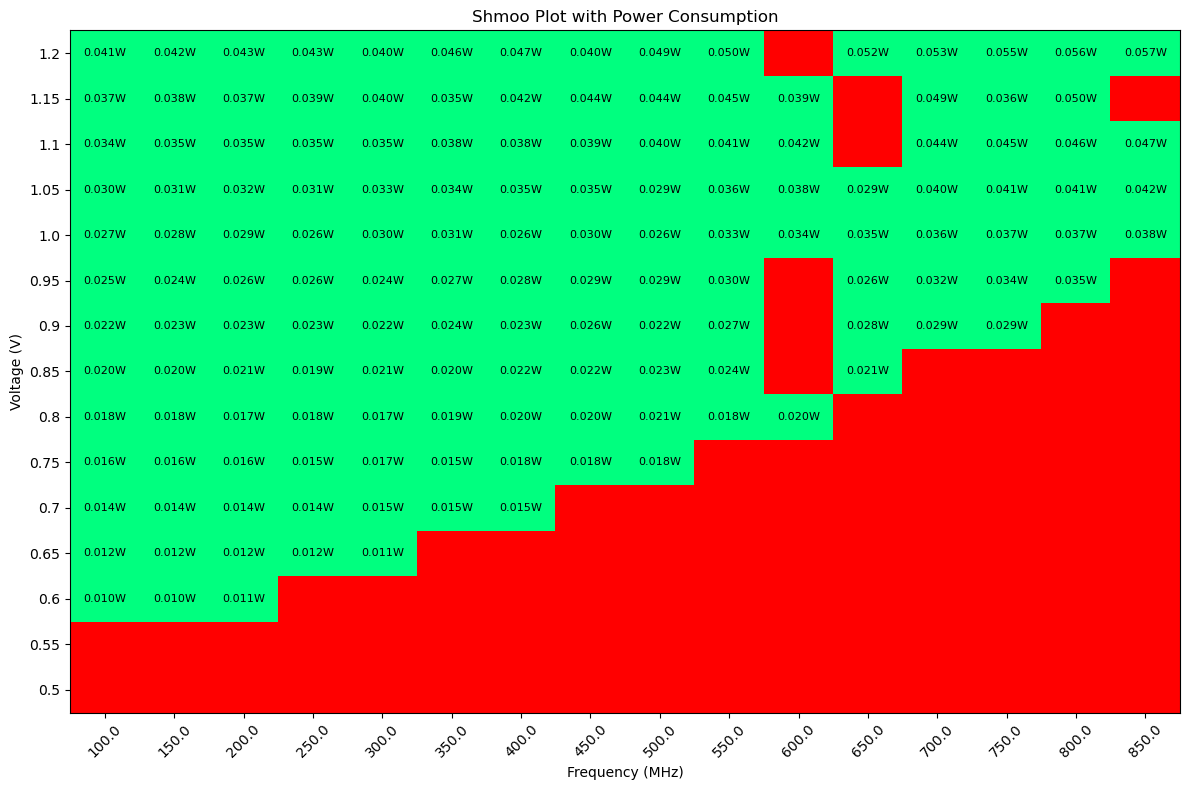

In [122]:
import matplotlib.pyplot as plt
import numpy as np

def read_data(file_name):
    freq_values = []
    voltage_values = []
    valid_values = []
    power_values = []

    with open(file_name, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            freq = float(parts[0].split(': ')[1])
            voltage = round(float(parts[1].split(': ')[1]), 2)
            valid = parts[2].split(': ')[1]
            power = float(parts[3].split(': ')[1])

            freq_values.append(freq)
            voltage_values.append(voltage)
            valid_values.append(valid)
            power_values.append(power)
    
    return freq_values, voltage_values, valid_values, power_values

file_name = '../../output.txt'

freq_values, voltage_values, valid_values, power_values = read_data(file_name)

unique_freqs = np.unique(freq_values)
unique_voltages = np.unique(voltage_values)

shmoo_plot = np.zeros((len(unique_voltages), len(unique_freqs)))
power_plot = np.zeros((len(unique_voltages), len(unique_freqs)))

for i, freq in enumerate(unique_freqs):
    for j, voltage in enumerate(unique_voltages):
        validity = valid_values[i * len(unique_voltages) + j]
        if validity == "Valid":
            shmoo_plot[j, i] = 1
            power_plot[j, i] = power_values[i * len(unique_voltages) + j]

plt.figure(figsize=(12, 8))

cmap = plt.cm.colors.ListedColormap(['red', 'springgreen'])

plt.imshow(shmoo_plot, cmap=cmap, aspect='auto', origin='lower')

for i in range(len(unique_freqs)):
    for j in range(len(unique_voltages)):
        if shmoo_plot[j, i] == 1:  # Valid
            plt.text(i, j, f'{power_plot[j, i]:.3f}W', ha='center', va='center', fontsize=8, color='black')

plt.xlabel('Frequency (MHz)')
plt.ylabel('Voltage (V)')
plt.title('Shmoo Plot with Power Consumption')

plt.xticks(np.arange(len(unique_freqs)), unique_freqs, rotation=45)
plt.yticks(np.arange(len(unique_voltages)), unique_voltages)

plt.tight_layout()
plt.show()
